# Sign Language : Multi-class Classification


In [4]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

Download the training and test sets (the test set will actually be used as a validation set):

In [1]:
!pip install gdown==4.6.0

  Using cached PySocks-1.7.1-py3-none-any.whl (16 kB)


You should consider upgrading via the 'D:\JetBrains\PyCharm Community Edition 2022.1\Enviroments\MachineLearning\Scripts\python.exe -m pip install --upgrade pip' command.


In [ ]:
# to download dataset
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

Define some globals with the path to both files you just downloaded:

In [5]:
TRAINING_FILE = 'Data/sign_mnist_train.csv'
VALIDATION_FILE = 'Data/sign_mnist_test.csv'

In [8]:
with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line[:100]}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line[:100]}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13
Each subsequent line (data points) look like this:
3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,17


 ## Parsing the dataset


In [9]:
def parse_data_from_input(filename):
  """
  Parses the images and labels from a CSV file

  Args:
    filename (string): path to the CSV file

  Returns:
    images, labels: tuple of numpy arrays containing the images and labels
  """
  with open(filename) as file:
    csv_reader = csv.reader(file, delimiter=',')

    labels = []
    images = []

    next(csv_reader)

    for row in csv_reader:
      labels.append(row[0])
      images.append(np.array(row[1:], dtype='float').reshape(28, 28))

    labels = np.array(labels).astype('float')
    images = np.array(images)

    return images, labels

In [10]:
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


## Visualizing the numpy arrays containing images

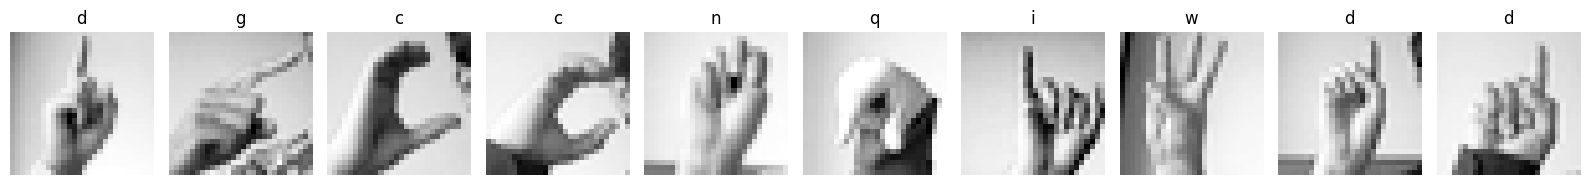

In [11]:
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

## Creating the generators for the CNN

In [12]:
from keras.utils import to_categorical # for one-hot encoding

def train_val_generators(training_images, training_labels, validation_images, validation_labels):
    
  training_images = np.expand_dims(training_images, axis=-1)# expanding dims for b&w color pixels
  validation_images = np.expand_dims(validation_images, axis=-1)

  train_datagen = ImageDataGenerator(rescale=1./255, #Image Data Generator with Augmentation
                                     rotation_range=40,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')


  train_generator = train_datagen.flow(x=training_images,
                                       y=to_categorical(training_labels, num_classes = 26),
                                       batch_size=32)


  validation_datagen = ImageDataGenerator(rescale=1./255)

  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=to_categorical(validation_labels, num_classes = 26),
                                                 batch_size=32)

  return train_generator, validation_generator

In [13]:
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455, 26)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172, 26)


## Coding the CNN

The architecture of the model.

In [14]:
from tensorflow.keras.optimizers import RMSprop

def create_model():
    
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPooling2D(2, 2),

      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(26, activation='softmax')
  ])


  model.compile(optimizer = RMSprop(learning_rate=1e-3),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [15]:
# Save your model
model = create_model()

# Train your model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)



Epoch 1/15


858/858 [==============================] - 22s 21ms/step - loss: 2.7409 - accuracy: 0.1710 - val_loss: 1.7407 - val_accuracy: 0.4346
Epoch 2/15
858/858 [==============================] - 18s 21ms/step - loss: 1.9102 - accuracy: 0.3920 - val_loss: 1.1201 - val_accuracy: 0.6007
Epoch 3/15
858/858 [==============================] - 19s 22ms/step - loss: 1.3983 - accuracy: 0.5485 - val_loss: 0.7895 - val_accuracy: 0.7468
Epoch 4/15
858/858 [==============================] - 18s 21ms/step - loss: 1.0811 - accuracy: 0.6434 - val_loss: 0.5592 - val_accuracy: 0.8094
Epoch 5/15
858/858 [==============================] - 18s 21ms/step - loss: 0.8906 - accuracy: 0.7041 - val_loss: 0.5299 - val_accuracy: 0.8236
Epoch 6/15
858/858 [==============================] - 18s 21ms/step - loss: 0.7356 - accuracy: 0.7536 - val_loss: 0.4104 - val_accuracy: 0.8617
Epoch 7/15
858/858 [==============================] - 18s 21ms/step - loss: 0.6384 - accuracy: 0.7865 - val_loss: 0.2197 - val_accur

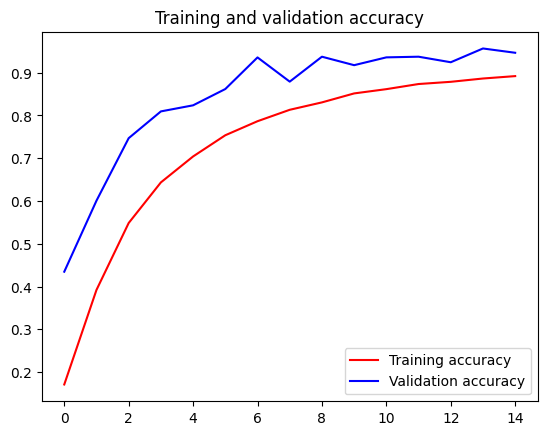

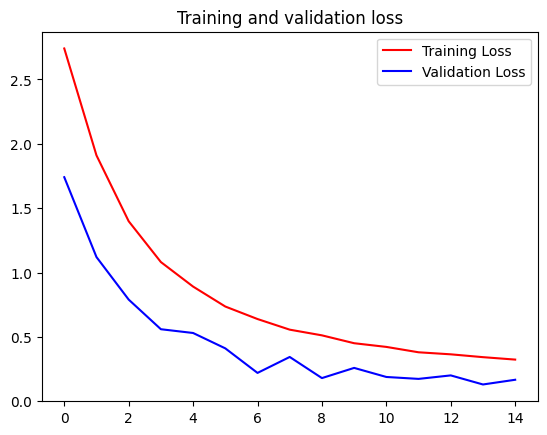

In [16]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [39]:
import numpy as np
import os
from tensorflow.keras.utils import load_img, img_to_array

for fn in os.listdir("Sample"):
 
    # predicting images
    path='Sample/' + fn
    img=load_img(path, target_size=(28, 28, 1), color_mode='grayscale')
    
    x=img_to_array(img)
    x /= 255
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])
    
    classes = model.predict(images, batch_size=10)
    
    # print(classes[0]) # weights of all the classes
    
    labels = dict((i, chr(i)) for i in range(97, 97+26))
    print("Filename: ", fn, " classified as ", labels[np.argmax(classes[0]) + 97])
    
    

1/1 [==============================] - 0s 28ms/step
Filename:  a.png  classified as  a
1/1 [==============================] - 0s 13ms/step
Filename:  b.png  classified as  b
1/1 [==============================] - 0s 20ms/step
Filename:  c.png  classified as  c
1/1 [==============================] - 0s 30ms/step
Filename:  d.png  classified as  t
1/1 [==============================] - 0s 35ms/step
Filename:  g.png  classified as  g
1/1 [==============================] - 0s 25ms/step
Filename:  h.png  classified as  h
1/1 [==============================] - 0s 33ms/step
Filename:  l.png  classified as  l
1/1 [==============================] - 0s 28ms/step
Filename:  m.png  classified as  m
1/1 [==============================] - 0s 31ms/step
Filename:  n.png  classified as  n
1/1 [==============================] - 0s 20ms/step
Filename:  o.png  classified as  o
1/1 [==============================] - 0s 26ms/step
Filename:  q.png  classified as  q
1/1 [==============================] - 0s 2